In [12]:
import pandas as pd
import numpy as np
import os

# Load index files
base_path = './mtc-aic3_dataset/'  # Replace with the path to the dataset directory if needed
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
validation_df = pd.read_csv(os.path.join(base_path, 'validation.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))

# Function to load a trial's EEG data
def load_trial_data(row, base_path='.'):
    # Determine dataset type based on ID range
    id_num = row['id']
    if id_num <= 4800:
        dataset = 'train'
    elif id_num <= 4900:
        dataset = 'validation'
    else:
        dataset = 'test'
    
    # Construct the path to EEGdata.csv
    eeg_path = f"{base_path}/{row['task']}/{dataset}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    
    # Load the entire EEG file
    eeg_data = pd.read_csv(eeg_path)
    
    # Calculate indices for the specific trial
    trial_num = int(row['trial'])
    if row['task'] == 'MI':
        samples_per_trial = 2250  # 9 seconds * 250 Hz
    else:  # SSVEP
        samples_per_trial = 1750  # 7 seconds * 250 Hz
    
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial - 1
    
    # Extract the trial data
    trial_data = eeg_data.iloc[start_idx:end_idx+1]
    return trial_data

# Example: Load data for the first training example
first_trial = validation_df.iloc[0]  # Using index 0 for the first row
trial_data = load_trial_data(first_trial, base_path=base_path)  # Pass the base_path parameter
print(f"Loaded task: {first_trial['task']}, Trial: {first_trial['trial']} for subject {first_trial['subject_id']}")
# Print label if available (only for training and validation data)
if 'label' in first_trial:
    print(f"Label: {first_trial['label']}")
print(f"Data shape: {trial_data.shape}")
print(f"First 5 rows of trial data:\n{trial_data.head()}")

Loaded task: MI, Trial: 1 for subject S31
Label: Left
Data shape: (2250, 18)
First 5 rows of trial data:
           Time            FZ            C3            CZ            C4  \
0  1.000500e+06  311426.59375  321080.50000  359498.84375  368457.43750   
1  1.000500e+06  309546.00000  311528.53125  352108.31250  366678.78125   
2  1.000500e+06  310267.96875  312397.37500  355520.78125  368320.65625   
3  1.000500e+06  312545.87500  322326.75000  364975.56250  371095.56250   
4  1.000500e+06  313246.21875  327401.46875  367259.75000  371133.31250   

             PZ           PO7            OZ           PO8      AccX      AccY  \
0  317776.90625  298857.40625  288538.78125  313009.37500  0.000244  0.820801   
1  309605.56250  296327.18750  287078.75000  310669.50000  0.002197  0.819092   
2  311393.15625  298072.96875  288286.65625  311938.46875  0.005127  0.819580   
3  320610.21875  301668.00000  290481.21875  315051.06250  0.009277  0.818359   
4  324231.18750  302074.53125  290579.9

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class EEGDataset(Dataset):
    def __init__(self, dataframe, base_path='.', task=None):
        if task is not None:
            self.dataframe = dataframe[dataframe['task'] == task].reset_index(drop=True)
        else:
            self.dataframe = dataframe
        self.base_path = base_path

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        trial_data = load_trial_data(row, base_path=self.base_path)
        label = row.get('label', None)  
        return trial_data, label

class EEGDataLoader(DataLoader):
    def __init__(self, dataframe, batch_size=32, shuffle=True, num_workers=0, base_path='.', task=None):
        dataset = EEGDataset(dataframe, base_path=base_path, task=task)
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [3]:
import torch
torch.manual_seed(42) 

In [4]:
train_loader = EEGDataLoader(train_df, batch_size=32, base_path=base_path,task='MI')
validation_loader = EEGDataLoader(validation_df, batch_size=32, base_path=base_path, task='MI')
test_loader = EEGDataLoader(test_df, batch_size=32, base_path=base_path, task='MI')

In [5]:
left_count = train_df['label'].value_counts().get('Left', 0)
right_count = train_df['label'].value_counts().get('Right', 0)
print(f"Left: {left_count}, Right: {right_count}")

Left: 1772, Right: 1812


# Preprocessing

In [2]:
from preprocessor import EEGPreprocessor

In [9]:
def preprocess_dataset_with_ica(df=None,
                               num_trials=5,
                               save_results=True,
                               task='MI',
                               data_split='train',):
    # Use the provided dataframe
    if df is None:
        raise ValueError("You must provide a dataframe (df) as an argument.")

    # Initialize preprocessor
    preprocessor = EEGPreprocessor()

    preprocessed_trials = []
    preprocessing_reports = []

    # Filter for MI task and select trials
    mi_trials = df[df['task'] == task].reset_index(drop=True)
    num_trials = min(num_trials, len(mi_trials))

    for i in range(num_trials):
        trial_row = mi_trials.iloc[i]
        trial_data = load_trial_data(trial_row, base_path=base_path)
        original_eeg = trial_data[preprocessor.eeg_channels].values

        preprocessed_eeg, preprocessing_info = preprocessor.preprocess_trial(
            trial_data,
            apply_bandpass=True,
            apply_notch=True,
            remove_baseline_drift=True,
            detect_bad_channels_flag=True,
            apply_ica_flag=True,
            standardize=True
        )

        trial_info = {
            'id': trial_row['id'],
            'task': trial_row['task'],
            'subject_id': trial_row['subject_id'],
            'trial': trial_row['trial'],
            'label': trial_row.get('label', 'Unknown')
        }

        preprocessed_trials.append({
            'trial_info': trial_info,
            'original_data': original_eeg,
            'preprocessed_data': preprocessed_eeg,
            'preprocessing_info': preprocessing_info
        })

        preprocessing_reports.append(preprocessing_info)

        if i == 0:
            preprocessor.plot_preprocessing_comparison(original_eeg, preprocessed_eeg, trial_info)

    if save_results:
        output_dir = f'preprocessed_{data_split}'
        os.makedirs(output_dir, exist_ok=True)

        for i, trial_result in enumerate(preprocessed_trials):
            filename = f"{output_dir}/trial_{trial_result['trial_info']['id']}_preprocessed.npz"
            np.savez(filename, 
                    preprocessed_data=trial_result['preprocessed_data'],
                    original_data=trial_result['original_data'],
                    trial_info=trial_result['trial_info'],
                    preprocessing_info=trial_result['preprocessing_info'])

        print(f"\n✓ Saved {len(preprocessed_trials)} preprocessed trials to {output_dir}/")

    return preprocessed_trials, preprocessing_reports


Starting EEG Preprocessing with ICA...
This will process 5 validation trials as an example.
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)


c:\Users\halim\OneDrive\Desktop\TheBrainTrust\preprocessor.py:257: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  standardized_data[:, i] = zscore(data[:, i])
c:\Users\halim\OneDrive\Desktop\TheBrainTrust\preprocessor.py:257: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  standardized_data[:, i] = zscore(data[:, i])
c:\Users\halim\OneDrive\Desktop\TheBrainTrust\preprocessor.py:257: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  standardized_data[:, i] = zscore(data[:, i])
c:\Users\halim\OneDrive\Desktop\TheBrainTrust\preprocessor.py:257: RuntimeWarning: Precision loss occurred in moment calculation due to catastrop

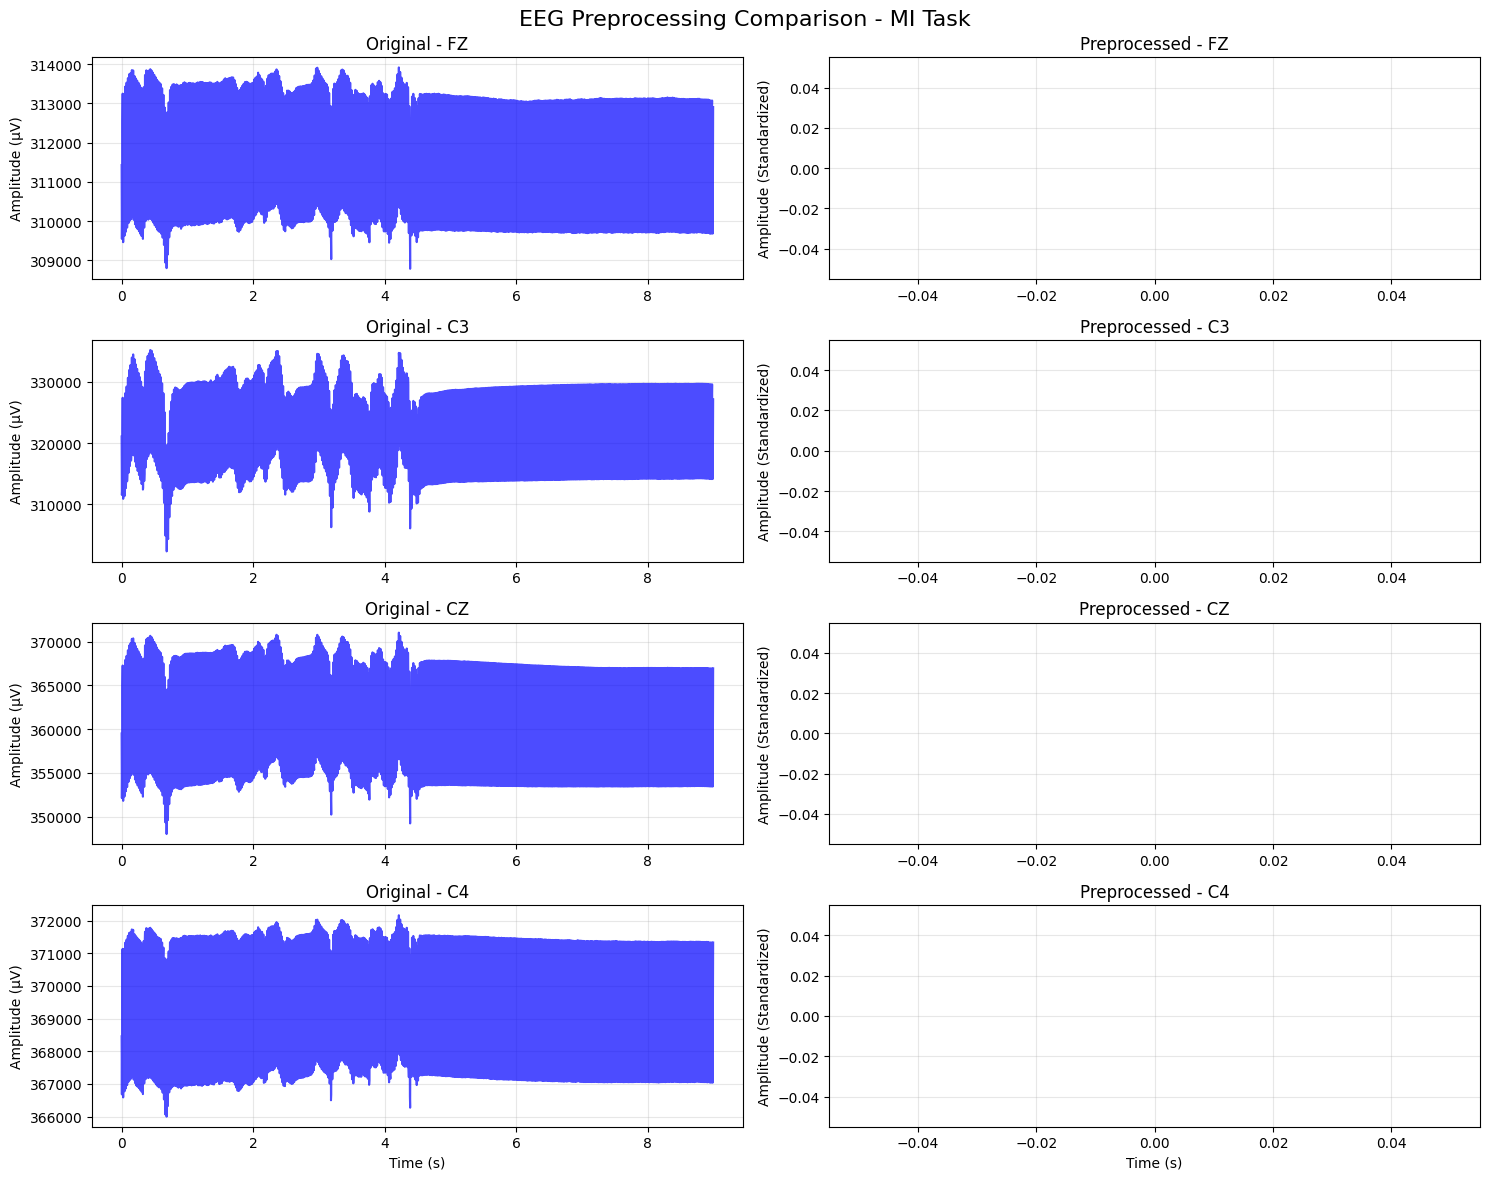

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baselin

C:\Users\halim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [13]:
base_path = './mtc-aic3_dataset/'
    
print("Starting EEG Preprocessing with ICA...")
print("This will process 5 validation trials as an example.")
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
validation_df = pd.read_csv(os.path.join(base_path, 'validation.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))
# Process some validation trials
trials, reports = preprocess_dataset_with_ica(
    data_split='validation',
    df=validation_df,
    num_trials=5,
    save_results=False
)

print(f"\n{'='*60}")
print("PREPROCESSING SUMMARY")
print(f"{'='*60}")
print(f"Processed {len(trials)} trials successfully")

# Print summary statistics
for i, report in enumerate(reports):
    print(f"\nTrial {i+1}:")
    print(f"  - Bad channels: {len(report['bad_channels'])}")
    print(f"  - ICA components removed: {len(report['ica_components_removed'])}")
    print(f"  - Preprocessing steps: {', '.join(report['preprocessing_steps'])}")

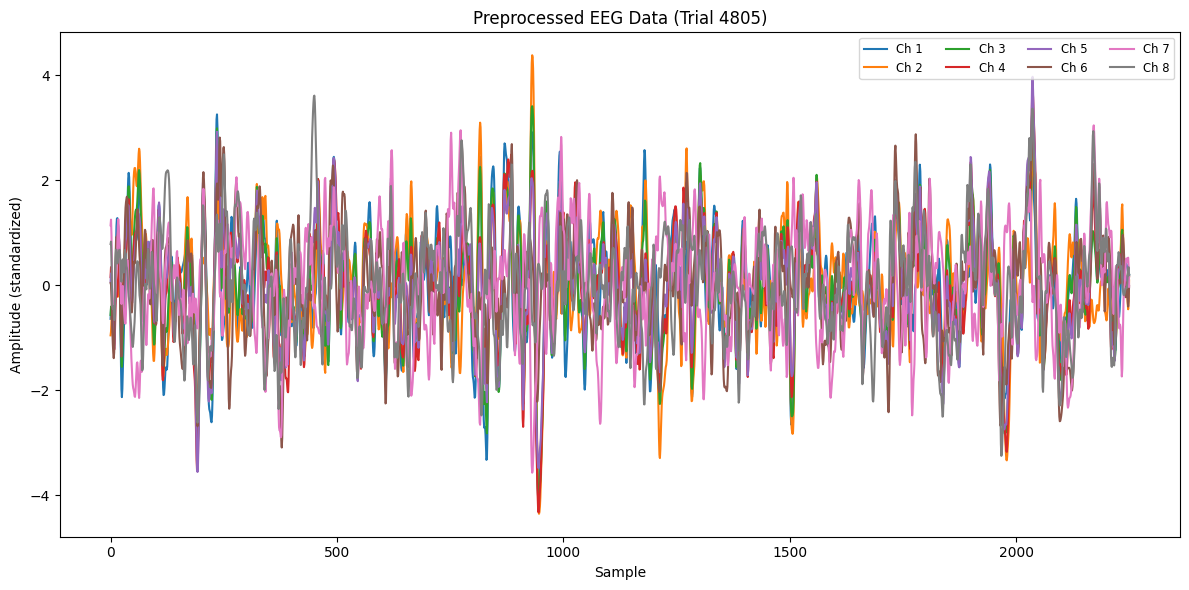

In [14]:
import matplotlib.pyplot as plt

# Plot the preprocessed EEG data from the last trial in 'trials'
preprocessed_eeg = trials[i]['preprocessed_data']

plt.figure(figsize=(12, 6))
for ch in range(preprocessed_eeg.shape[1]):
    plt.plot(preprocessed_eeg[:, ch], label=f'Ch {ch+1}')
plt.title('Preprocessed EEG Data (Trial {})'.format(trials[i]['trial_info']['id']))
plt.xlabel('Sample')
plt.ylabel('Amplitude (standardized)')
plt.legend(loc='upper right', ncol=4, fontsize='small')
plt.tight_layout()
plt.show()

Starting EEG Preprocessing with ICA...
This will process 5 validation trials as an example.
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)


c:\Users\halim\OneDrive\Desktop\TheBrainTrust\preprocessor.py:257: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  standardized_data[:, i] = zscore(data[:, i])
c:\Users\halim\OneDrive\Desktop\TheBrainTrust\preprocessor.py:257: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  standardized_data[:, i] = zscore(data[:, i])
c:\Users\halim\OneDrive\Desktop\TheBrainTrust\preprocessor.py:257: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  standardized_data[:, i] = zscore(data[:, i])
c:\Users\halim\OneDrive\Desktop\TheBrainTrust\preprocessor.py:257: RuntimeWarning: Precision loss occurred in moment calculation due to catastrop

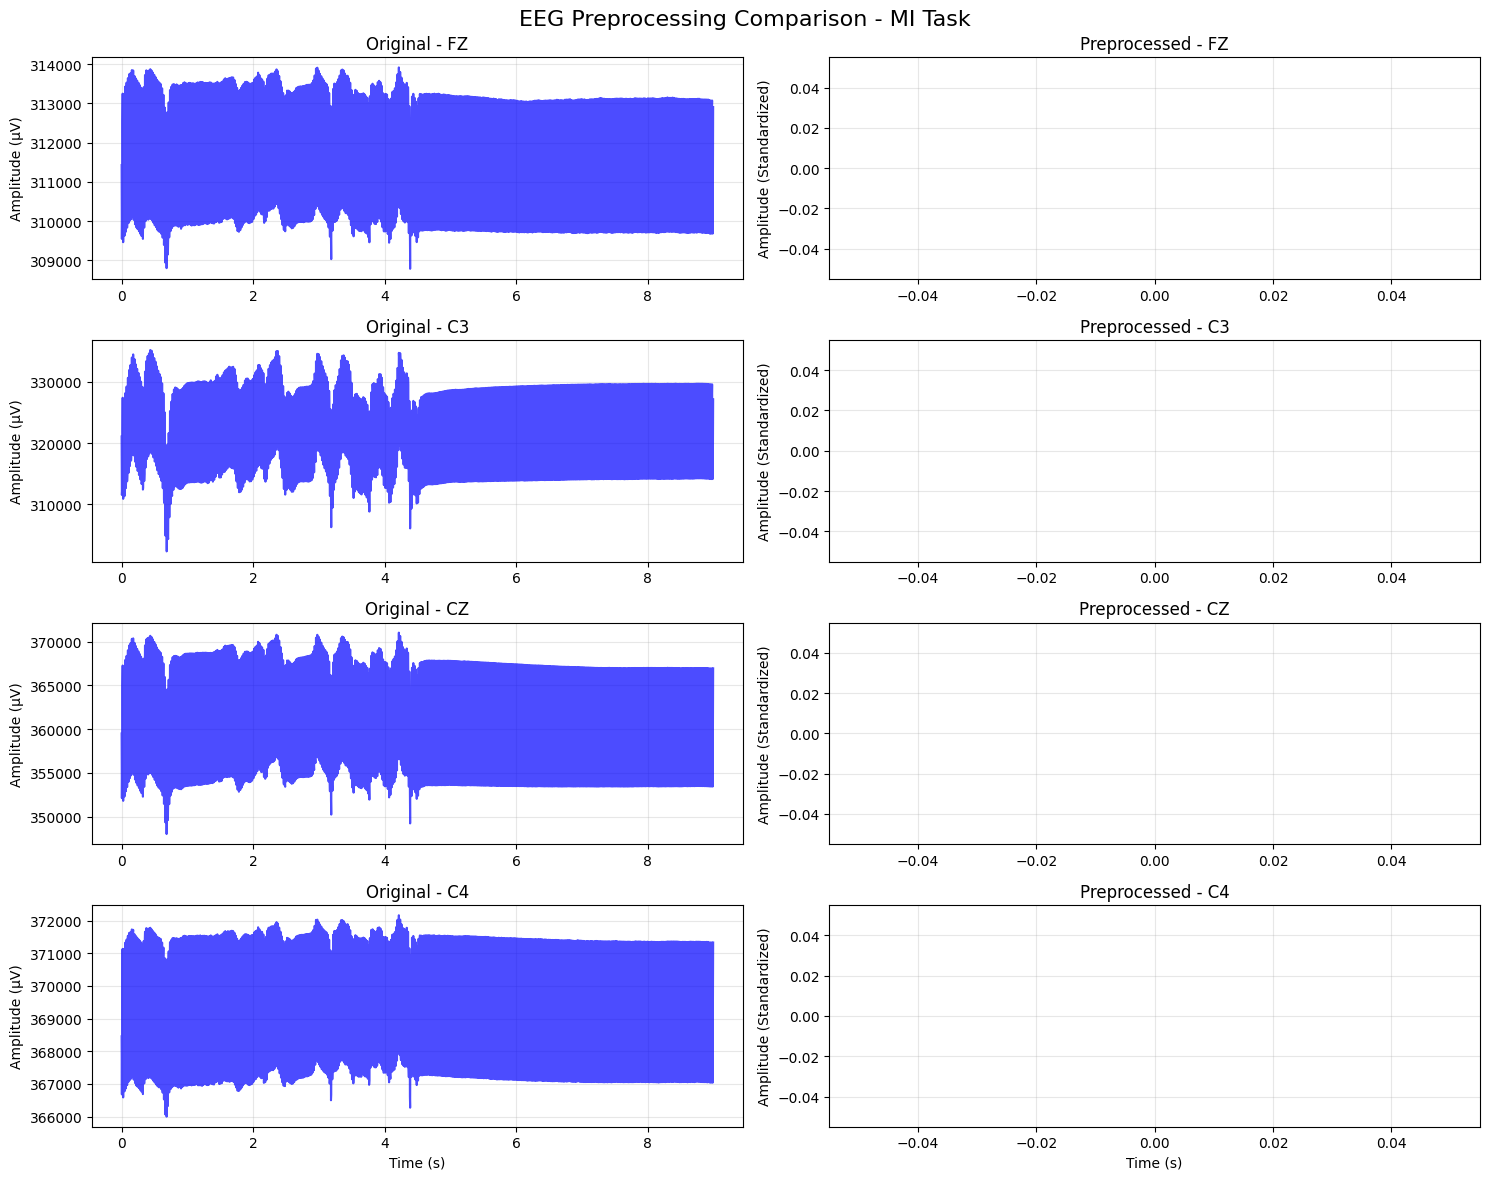

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baselin

C:\Users\halim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [15]:
# Process some validation trials
train_trials, reports = preprocess_dataset_with_ica(
    data_split='validation',
    df=validation_df,
    num_trials=5,
    save_results=False
)

print(f"\n{'='*60}")
print("PREPROCESSING SUMMARY")
print(f"{'='*60}")
print(f"Processed {len(trials)} trials successfully")

# Print summary statistics
for i, report in enumerate(reports):
    print(f"\nTrial {i+1}:")
    print(f"  - Bad channels: {len(report['bad_channels'])}")
    print(f"  - ICA components removed: {len(report['ica_components_removed'])}")
    print(f"  - Preprocessing steps: {', '.join(report['preprocessing_steps'])}")

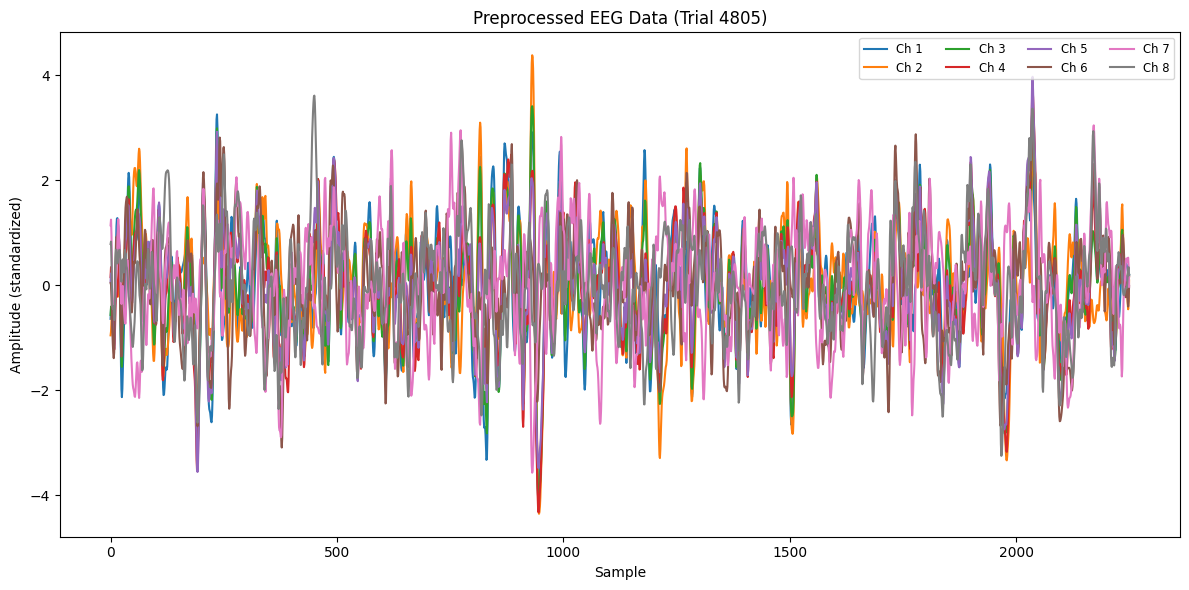

In [16]:
import matplotlib.pyplot as plt

# Plot the preprocessed EEG data from the last trial in 'trials'
preprocessed_eeg = train_trials[i]['preprocessed_data']

plt.figure(figsize=(12, 6))
for ch in range(preprocessed_eeg.shape[1]):
    plt.plot(preprocessed_eeg[:, ch], label=f'Ch {ch+1}')
plt.title('Preprocessed EEG Data (Trial {})'.format(trials[i]['trial_info']['id']))
plt.xlabel('Sample')
plt.ylabel('Amplitude (standardized)')
plt.legend(loc='upper right', ncol=4, fontsize='small')
plt.tight_layout()
plt.show()

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)


c:\Users\halim\OneDrive\Desktop\TheBrainTrust\preprocessor.py:257: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  standardized_data[:, i] = zscore(data[:, i])
c:\Users\halim\OneDrive\Desktop\TheBrainTrust\preprocessor.py:257: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  standardized_data[:, i] = zscore(data[:, i])
c:\Users\halim\OneDrive\Desktop\TheBrainTrust\preprocessor.py:257: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  standardized_data[:, i] = zscore(data[:, i])
c:\Users\halim\OneDrive\Desktop\TheBrainTrust\preprocessor.py:257: RuntimeWarning: Precision loss occurred in moment calculation due to catastrop

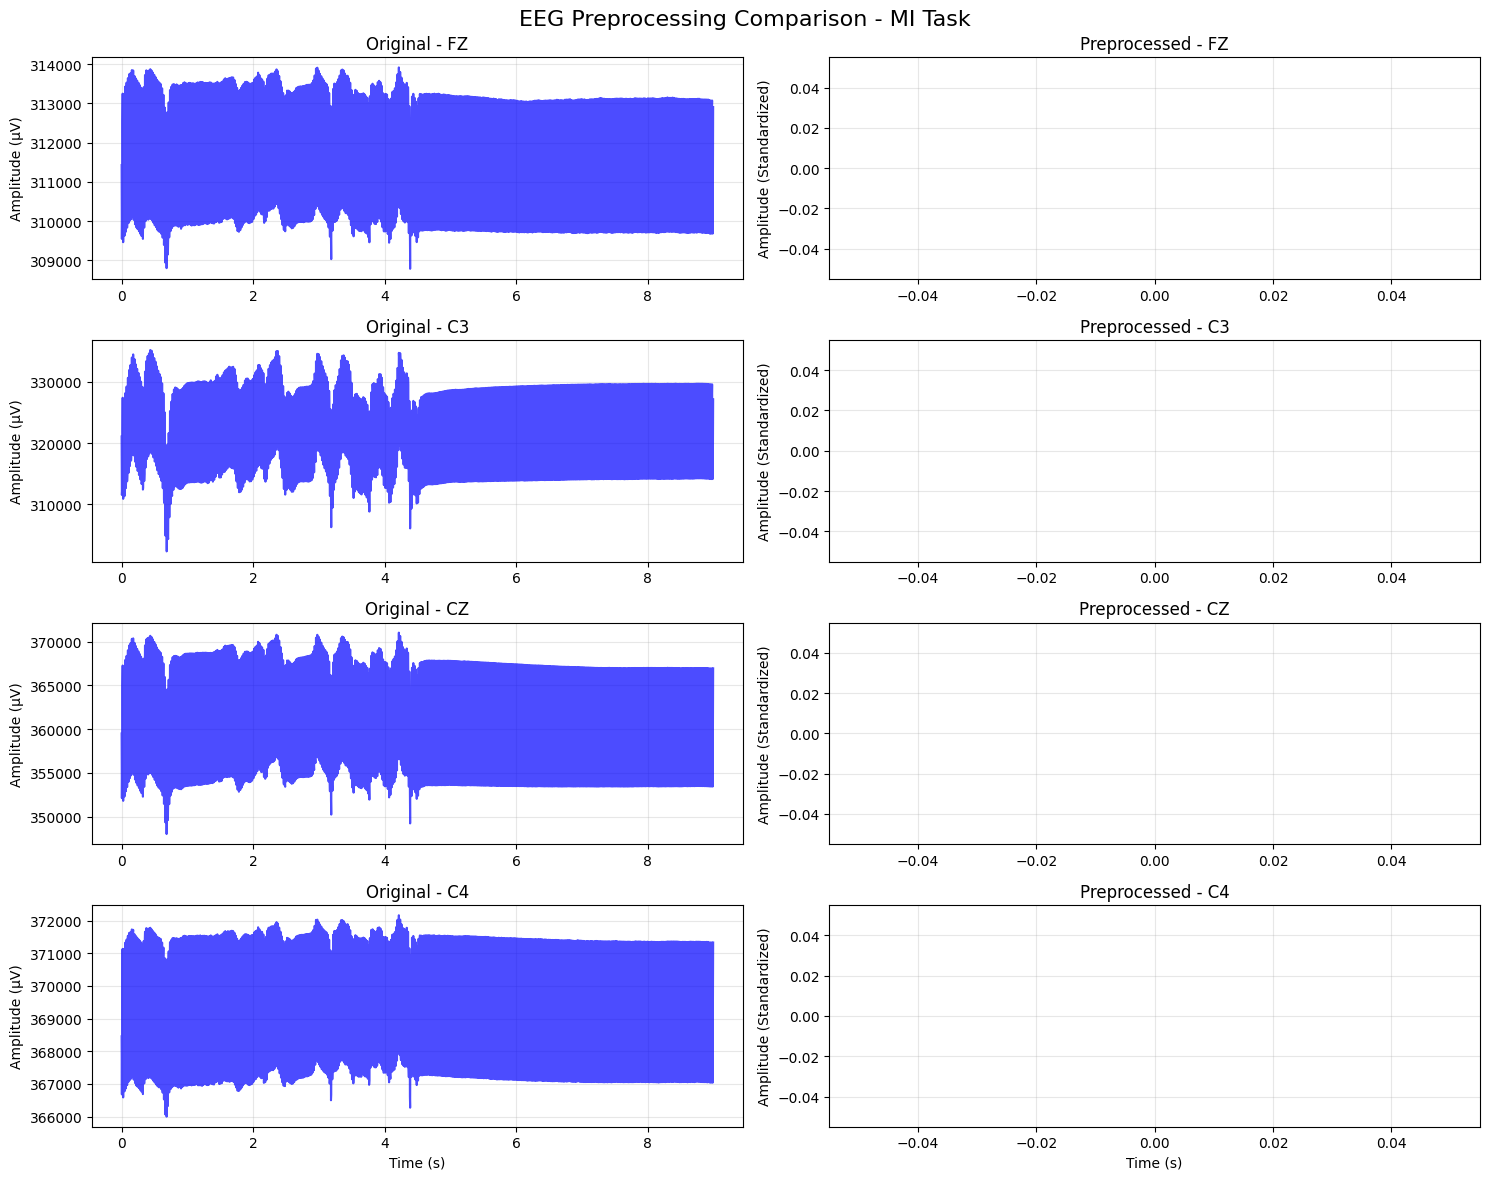

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baselin

C:\Users\halim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [17]:
# Process some validation trials
test_trials, reports = preprocess_dataset_with_ica(
    data_split='validation',
    df=validation_df,
    num_trials=5,
    save_results=False
)

print(f"\n{'='*60}")
print("PREPROCESSING SUMMARY")
print(f"{'='*60}")
print(f"Processed {len(trials)} trials successfully")

# Print summary statistics
for i, report in enumerate(reports):
    print(f"\nTrial {i+1}:")
    print(f"  - Bad channels: {len(report['bad_channels'])}")
    print(f"  - ICA components removed: {len(report['ica_components_removed'])}")
    print(f"  - Preprocessing steps: {', '.join(report['preprocessing_steps'])}")

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

class PreprocessedEEGDataset(Dataset):
    def __init__(self, preprocessed_trials, return_features=False, return_raw=True):
        """
        PyTorch Dataset for preprocessed EEG trials
        
        Parameters:
        preprocessed_trials: list, output from CompleteBCIPipeline.process_dataset()
                           Each item should be a dict with keys:
                           - 'trial_info': dict with trial metadata
                           - 'preprocessed_data': numpy array of preprocessed EEG
                           - 'original_data': numpy array of original EEG
                           - 'preprocessing_info': dict with preprocessing details
        return_features: bool, if True returns extracted features instead of raw EEG
        return_raw: bool, if True returns raw preprocessed EEG data
        """
        self.preprocessed_trials = preprocessed_trials
        self.return_features = return_features
        self.return_raw = return_raw
        
        # Extract labels and task info
        self.labels = []
        self.tasks = []
        
        for trial in preprocessed_trials:
            trial_info = trial['trial_info']
            self.labels.append(trial_info.get('label', 'Unknown'))
            self.tasks.append(trial_info.get('task', 'Unknown'))
        
        # Create label mapping for each task
        self.label_mappings = self._create_label_mappings()
        
    def _create_label_mappings(self):
        """Create label mappings for different tasks"""
        unique_tasks = list(set(self.tasks))
        label_mappings = {}
        
        for task in unique_tasks:
            task_labels = [label for i, label in enumerate(self.labels) if self.tasks[i] == task]
            unique_labels = sorted(list(set(task_labels)))
            label_mappings[task] = {label: idx for idx, label in enumerate(unique_labels)}
        
        return label_mappings
    
    def __len__(self):
        return len(self.preprocessed_trials)
    
    def __getitem__(self, idx):
        trial = self.preprocessed_trials[idx]
        
        # Get trial info
        trial_info = trial['trial_info']
        task = trial_info['task']
        label_str = trial_info.get('label', 'Unknown')
        
        # Convert string label to numeric
        if label_str in self.label_mappings[task]:
            label = self.label_mappings[task][label_str]
        else:
            label = -1  # Unknown label
        
        if self.return_features:
            # Return extracted features (if available)
            if 'features' in trial:
                data = torch.FloatTensor(trial['features'])
            else:
                # Extract features on-the-fly (basic version)
                eeg_data = trial['preprocessed_data']
                data = torch.FloatTensor(self._extract_simple_features(eeg_data))
        else:
            # Return raw preprocessed EEG data
            eeg_data = trial['preprocessed_data']
            
            if self.return_raw:
                # Shape: (samples, channels) -> (channels, samples) for PyTorch
                data = torch.FloatTensor(eeg_data.T)
            else:
                # Keep original shape
                data = torch.FloatTensor(eeg_data)
        
        # Return data, label, and metadata
        metadata = {
            'task': task,
            'subject_id': trial_info.get('subject_id', 'Unknown'),
            'trial_id': trial_info.get('id', -1),
            'original_label': label_str
        }
        
        return data, label, metadata
    
    def _extract_simple_features(self, eeg_data):
        """Extract simple features if not pre-computed"""
        # Basic statistical features for each channel
        features = []
        for ch in range(eeg_data.shape[1]):
            channel_data = eeg_data[:, ch]
            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.var(channel_data)
            ])
        return np.array(features)
    
    def get_task_info(self):
        """Get information about tasks and labels"""
        info = {}
        for task, mapping in self.label_mappings.items():
            task_count = sum(1 for t in self.tasks if t == task)
            info[task] = {
                'count': task_count,
                'labels': mapping,
                'n_classes': len(mapping)
            }
        return info

class EEGDataLoader(DataLoader):
    def __init__(self, preprocessed_trials, batch_size=32, shuffle=True, 
                 num_workers=0, task_filter=None, return_features=False, 
                 return_raw=True, **kwargs):
        """
        PyTorch DataLoader for preprocessed EEG trials
        
        Parameters:
        preprocessed_trials: list, output from CompleteBCIPipeline.process_dataset()
        batch_size: int, batch size for training
        shuffle: bool, whether to shuffle data
        num_workers: int, number of worker processes
        task_filter: str, filter by specific task ('MI' or 'SSVEP')
        return_features: bool, return extracted features instead of raw EEG
        return_raw: bool, return raw preprocessed EEG data
        **kwargs: additional arguments for DataLoader
        """
        
        # Filter by task if specified
        if task_filter is not None:
            filtered_trials = []
            for trial in preprocessed_trials:
                if trial['trial_info']['task'] == task_filter:
                    filtered_trials.append(trial)
            preprocessed_trials = filtered_trials
        
        # Create dataset
        dataset = PreprocessedEEGDataset(
            preprocessed_trials, 
            return_features=return_features,
            return_raw=return_raw
        )
        
        # Initialize DataLoader
        super().__init__(
            dataset, 
            batch_size=batch_size, 
            shuffle=shuffle, 
            num_workers=num_workers,
            **kwargs
        )
        
        self.task_info = dataset.get_task_info()
    
    def get_label_mappings(self):
        """Get label mappings for all tasks"""
        return self.dataset.label_mappings
    
    def print_info(self):
        """Print information about the dataset"""
        print("EEG DataLoader Information:")
        print("=" * 40)
        for task, info in self.task_info.items():
            print(f"Task: {task}")
            print(f"  - Trials: {info['count']}")
            print(f"  - Classes: {info['n_classes']}")
            print(f"  - Labels: {info['labels']}")
            print()
class TaskSpecificDataLoader:
    """Helper class to create separate DataLoaders for each task"""
    def __init__(self, preprocessed_trials, batch_size=32, shuffle=True, num_workers=0):
        self.preprocessed_trials = preprocessed_trials
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        
        # Get unique tasks
        self.tasks = list(set([trial['trial_info']['task'] for trial in preprocessed_trials]))
        
        # Create DataLoaders for each task
        self.dataloaders = {}
        for task in self.tasks:
            self.dataloaders[task] = EEGDataLoader(
                preprocessed_trials,
                batch_size=batch_size,
                shuffle=shuffle,
                num_workers=num_workers,
                task_filter=task
            )
    
    def get_dataloader(self, task):
        """Get DataLoader for specific task"""
        return self.dataloaders.get(task, None)
    
    def get_all_dataloaders(self):
        """Get all DataLoaders"""
        return self.dataloaders
    
    def print_info(self):
        """Print information about all DataLoaders"""
        for task, dataloader in self.dataloaders.items():
            print(f"\n{task} Task:")
            dataloader.print_info()

In [23]:
def create_dataloaders_from_pipeline_results(train_trials, val_trials, test_trials=None, 
                                            batch_size=32, num_workers=0):
    """
    Create DataLoaders from the output of CompleteBCIPipeline.process_dataset()
    
    Parameters:
    train_trials: list, preprocessed training trials
    val_trials: list, preprocessed validation trials  
    test_trials: list, preprocessed test trials (optional)
    batch_size: int, batch size
    num_workers: int, number of workers
    
    Returns:
    dict with DataLoaders for train, validation, and optionally test
    """
    
    dataloaders = {}
    
    # Training DataLoader
    dataloaders['train'] = EEGDataLoader(
        train_trials,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # Validation DataLoader
    dataloaders['val'] = EEGDataLoader(
        val_trials,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    
    # Test DataLoader (if provided)
    if test_trials is not None:
        dataloaders['test'] = EEGDataLoader(
            test_trials,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers
        )
    
    return dataloaders



In [24]:
dataloaders = create_dataloaders_from_pipeline_results(
    train_trials=train_trials,
    val_trials=trials, 
    test_trials=test_trials,
    batch_size=32,
    num_workers=2
)

# Access DataLoaders
train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']